In [ ]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as torch_optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

In [ ]:
print(torch.cuda.device_count())            # Numero di GPU disponibili
print(torch.cuda.get_device_name(0))        # Nome della prima GPU disponibile
print(torch.cuda.current_device())        # Device in uso al momento
print(torch.cuda.set_device(0))             # Imposta la prima GPU come default
print(torch.cuda.get_device_capability(0))  # Verifica le capacità della prima GPU

1
Tesla T4
0
None
(7, 5)


In [ ]:
path = './drive/MyDrive/Materiale_Pellegrino_personal/NSLKDD/NSLKDD_Full.csv'
dataset = pd.read_csv(path)

In [ ]:
# Elimino la colonna 'num_access_files' poiché inutile
dataset = dataset.drop('num_access_files', axis=1)

# Elimino la colonna 'binlabel' dal dataset
dataset = dataset.drop('binlabel', axis=1)

In [ ]:
dep_var = 'label'
cat_names = ["protocol_type", "service", "flag"]
cont_names = [col for col in dataset.columns if col not in cat_names and col != dep_var]

In [ ]:
# LabelEncoding della variabile target 
target_index = dataset.columns.get_loc(dep_var)
dataset.iloc[:, target_index] = LabelEncoder().fit_transform(dataset[dep_var])

#LabelEncoding delle variabili categoriali
for col in cat_names:
  target_index = dataset.columns.get_loc(col)
  dataset.iloc[:, target_index] = LabelEncoder().fit_transform(dataset[col])

In [ ]:
from sklearn.model_selection import train_test_split

# train 50% e test 50%
train, test = train_test_split(dataset, test_size=0.50)

In [ ]:
y_train = train[dep_var]
train = train.drop(dep_var, axis=1)
y_test = test[dep_var]
test = test.drop(dep_var, axis=1)

# validation di 2500 righe da train
train, validation, y_train, y_val = train_test_split(train, y_train, test_size=0.033666, random_state=0)

In [ ]:
y_train = y_train.values
y_test = y_test.values
y_val = y_val.values

In [ ]:
""" Making device (GPU/CPU) compatible

(borrowed from https://jovian.ml/aakashns/04-feedforward-nn)

In order to make use of a GPU if available, we'll have to move our data and model to it. """ 

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

device = get_default_device()
device

device(type='cuda')

In [ ]:
#### Fase di Categorical Embeddings ###############

for col in cat_names:
  train[col] = train[col].astype('category')

embedded_cols = {n: len(col.cat.categories) for n,col in train[cat_names].items()}
print(embedded_cols)

embedded_col_names = cat_names

# Determiniamo una funzione per la dimensione dell'incorporamento, presa da una libreria 
embedding_sizes = [(n_categories, min(50, (n_categories+1)//2)) for _,n_categories in embedded_cols.items()]
embedding_sizes

{'protocol_type': 3, 'service': 69, 'flag': 11}


[(3, 2), (69, 35), (11, 6)]

In [ ]:
""" Pytorch Dataset e DataLoader
Estendiamo la Dataset classe (astratta) fornita da Pytorch per un accesso più facile al nostro set di dati durante l'addestramento 
e per utilizzare efficacemente  il DataLoader modulo per gestire i batch. Ciò comporta la sovrascrittura dei metodi __len__e __getitem__
secondo il nostro particolare set di dati.
Poiché abbiamo solo bisogno di incorporare colonne categoriali, dividiamo il nostro input in due parti: numerico e categoriale. """ 

class NSLKDD_Dataset(Dataset):
    def __init__(self, X, Y, embedded_col_names):
        X = X.copy()
        self.X1 = X.loc[:,embedded_col_names].copy().values.astype(np.int64) #categorical columns
        self.X2 = X.drop(columns=embedded_col_names).copy().values.astype(np.float32) #numerical columns
        self.y = Y
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X1[idx], self.X2[idx], self.y[idx]
        
#creating train and valid datasets
train_ds = NSLKDD_Dataset(train, y_train, embedded_col_names)
valid_ds = NSLKDD_Dataset(validation, y_val, embedded_col_names)

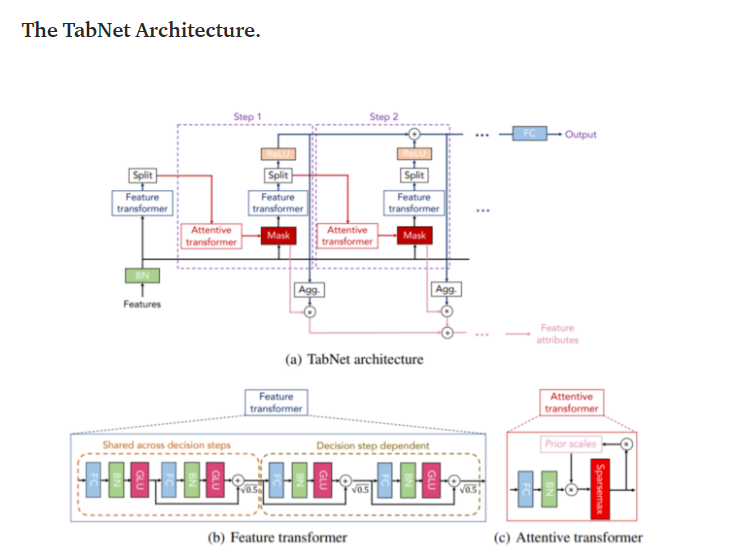

In [ ]:
""" Ghost Batch Normalization (GBN):
 Questa tenica ci consente di operare su grandi batch di dati e al tempo stesso ottenere buone generalizzazioni.
 In pratica: viene diviso il batch di in input in sotto-batch di dimensioni uguali (dimensione del batch 
 virtuale) e viene applicato lo stesso livello di Batch Normalization. 
 Tutti i layer di normalizzazione del modello, eccetto il primo, adottano questa tecnica. """

class GBN(nn.Module):
  def __init__(self,inp,vbs=128,momentum=0.01):
        super().__init__()
        self.bn = nn.BatchNorm1d(inp,momentum=momentum)
        self.vbs = vbs
        
  def forward(self,x):
        chunk = torch.chunk(x,x.size(0)//self.vbs,0)
        res = [self.bn(y) for y in chunk]
        return torch.cat(res,0)

""" SparseMax: 
  essa è una funzione di normalizzazione non lineare come Softmax ma con una distribuzione più sparsa.
  Ovvero rispetto a Softmax alcuni numeri nella distribuzione della probabilità di output sono molto vicini
  a 1 mentre altri molto più vicini a 0; ciò consente al modello di selezionare le caratteristiche rilevanti in 
  ogni fase deciionale in modo più efficace. 
  Useremo Sparsemax per progettare la maschera per il passaggio di selezione delle features su uno spazio più ristretto. """

!pip install -U sparsemax

from sparsemax import Sparsemax

""" Attention Transformer: 
  è la fase in cui modelli apprendono la relazione tra le caratteristiche rilevanti e decidono quali trasferire al Feature Transformer.
  Ciascun Attention Transformer è costituito da: 
    - un livello completamente connesso;
    - un livello di GBN;
    - un livello Sparsemax.
  L'attention transformer in ogni fase decisionale riceve le caratteristiche di input, quelle elaborate nella fase precedente e le informazioni preliminari
  sulle caratteristiche utilizzate. 
  Tutte queste info sono rappresentate da una matrice di dim batch_size x input_features. Essa viene aggiornata in ogni fase decisionale.
  Esiste anche un parametro di "rilassamento" che limita il numero di volte in cui una determinata funzione può essere utilizzata in un passaggio in avanti. """

class AttentionTransformer(nn.Module):

    def __init__(self,d_a,inp_dim,relax,vbs=128):
        super().__init__()
        self.fc = nn.Linear(d_a,inp_dim)
        #self.bn = GBN(out_dim,vbs=vbs)
        self.bn = GBN(inp_dim, vbs=vbs)
        self.smax = Sparsemax()
        self.r = relax
    
    #a:feature from previous decision step

    def forward(self,a,priors): 
        a = self.bn(self.fc(a)) 
        mask = self.smax(a*priors) 
        priors =priors*(self.r-mask)  #updating the prior
        return mask

""" Feautre Transformer: 
 Il trasformatore di caratteristiche è dove tutte le caratteristiche selezionate vengono elaborate per generare l'output finale. 
 
 Ogni trasformatore di caratteristiche è composto da più Gated Linear Unit Blocks.
 Una GLU controlla quali informazioni devono essere autorizzate a fluire ulteriormente attraverso la rete. 
 Per implementare un blocco GLU, prima raddoppiamo la dimensione delle caratteristiche di input alla GLU utilizzando uno strato completamente connesso.
 Normalizziamo la matrice risultante utilizzando un GBN Layer. Quindi, applichiamo un sigmoide alla seconda metà delle caratteristiche risultanti 
 e moltiplichiamo i risultati per la prima metà. Il risultato viene moltiplicato per un fattore di scala (sqrt (0,5) in questo caso) e aggiunto all'input. 
 Questo risultato sommato è l'input per il blocco GLU successivo nella sequenza.

 Un certo numero di blocchi GLU è condiviso tra tutte le fasi decisionali per promuovere la capacità e l'efficienza del modello (opzionale). 
 Il primo blocco GLU condiviso (o il primo blocco indipendente se non ci sono blocchi condivisi) è unico in quanto riduce la dimensione 
 delle features di input ad una dimensione uguale n_a + n_d. 
 n_a è la dimensione delle caratteristiche in ingresso al trasformatore di attenzione del passaggio successivo e 
 n_d è la dimensione delle caratteristiche utilizzate per calcolare i risultati finali. 
 Queste caratteristiche vengono elaborate insieme fino a raggiungere lo splitter. 
 L'attivazione di ReLU viene applicata al vettore dimensionato n_d. 
 Gli output di tutte le fasi decisionali vengono sommati e passati attraverso un livello completamente connesso per mapparli alla dimensione di output. """

class GLU(nn.Module):

  def __init__(self,inp_dim,out_dim,fc=None,vbs=128):
      super().__init__()
      if fc:
          self.fc = fc
      else:
          self.fc = nn.Linear(inp_dim,out_dim*2)
      self.bn = GBN(out_dim*2,vbs=vbs) 
      self.od = out_dim

  def forward(self,x):
      x = self.bn(self.fc(x))
      return x[:,:self.od]*torch.sigmoid(x[:,self.od:])

class FeatureTransformer(nn.Module):

  def __init__(self,inp_dim,out_dim,shared,n_ind,vbs=128):
      super().__init__()
      first = True
      self.shared = nn.ModuleList()
      if shared:
          self.shared.append(GLU(inp_dim,out_dim,shared[0],vbs=vbs))
          first= False    
          for fc in shared[1:]:
              self.shared.append(GLU(out_dim,out_dim,fc,vbs=vbs))
      else:
          self.shared = None
      self.independ = nn.ModuleList()
      if first:
          self.independ.append(GLU(inp,out_dim,vbs=vbs))
      for x in range(first, n_ind):
          self.independ.append(GLU(out_dim,out_dim,vbs=vbs))
      self.scale = torch.sqrt(torch.tensor([.5],device=device))

  def forward(self,x):
      if self.shared:
          x = self.shared[0](x)
          for glu in self.shared[1:]:
              x = torch.add(x, glu(x))
              x = x*self.scale
      for glu in self.independ:
          x = torch.add(x, glu(x))
          x = x*self.scale
      return x
      
""" Combiniamo Attention Transformer e Feature Transformer in un DecisionStep """

class DecisionStep(nn.Module):
  
    def __init__(self,inp_dim,n_d,n_a,shared,n_ind,relax,vbs=128):
        super().__init__()
        self.fea_tran = FeatureTransformer(inp_dim,n_d+n_a,shared,n_ind,vbs)
        self.atten_tran =  AttentionTransformer(n_a,inp_dim,relax,vbs)
    
    def forward(self,x,a,priors):
        mask = self.atten_tran(a,priors)
        sparse_loss = ((-1)*mask*torch.log(mask+1e-10)).mean()
        x = self.fea_tran(x*mask)
        return x,sparse_loss

Requirement already up-to-date: sparsemax in /usr/local/lib/python3.7/dist-packages (0.1.9)


In [ ]:
""" Creiamo ora il modello completo mediante gli elementi definiti """

class TabNet(nn.Module):
    def __init__(self,inp_dim, final_out_dim, n_d=32, n_a=32, n_shared=2, n_ind=2, n_steps=4, relax=1.2, vbs=128):
        super().__init__()
        if n_shared>0:
            self.shared = nn.ModuleList()
            self.shared.append(nn.Linear(inp_dim,2*(n_d+n_a)))
            for x in range(n_shared-1):
                self.shared.append(nn.Linear(n_d+n_a,2*(n_d+n_a)))
        else:
            self.shared=None
        self.first_step = FeatureTransformer(inp_dim,n_d+n_a,self.shared,n_ind) 
        self.steps = nn.ModuleList()
        for x in range(n_steps-1):
            self.steps.append(DecisionStep(inp_dim,n_d,n_a,self.shared,n_ind,relax,vbs))
        self.fc = nn.Linear(n_d,final_out_dim)
        self.bn = nn.BatchNorm1d(inp_dim)
        self.n_d = n_d

    def forward(self,x):
        x = self.bn(x)
        x_a = self.first_step(x)[:,self.n_d:]
        sparse_loss = torch.zeros(1).to(x.device)
        out = torch.zeros(x.size(0),self.n_d).to(x.device)
        priors = torch.ones(x.shape).to(x.device)
        for step in self.steps:
            x_te,l = step(x,x_a,priors)
            out += F.relu(x_te[:,:self.n_d])
            x_a = x_te[:,self.n_d:]
            sparse_loss += l
        return self.fc(out),sparse_loss

In [ ]:
class TabNetWithEmbed(nn.Module):
    def __init__(self,inp_dim,embedding_sizes,final_out_dim,n_d=64,n_a=64,n_shared=2,n_ind=2,n_steps=5,relax=1.2,vbs=128):
        super().__init__()
        n_emb = 0
        for i in range(len(embedding_sizes)):
          n_emb = n_emb + embedding_sizes[i][1]
        self.n_emb = n_emb
        self.cat_embed = []
        self.emb1 = nn.Embedding(embedding_sizes[0][0],embedding_sizes[0][1])
        self.emb2 = nn.Embedding(embedding_sizes[1][0],embedding_sizes[1][1])
        self.emb3 = nn.Embedding(embedding_sizes[2][0],embedding_sizes[2][1])
        self.cat_embed.append(self.emb1)
        self.cat_embed.append(self.emb2)
        self.cat_embed.append(self.emb3)
        self.tabnet = TabNet(inp_dim+self.n_emb,final_out_dim,n_d,n_a,n_shared,n_ind,n_steps,relax,vbs)
        
    def forward(self,catv,contv):
        catv = catv.to(device)
        contv = contv.to(device)
        embeddings = [embed(catv[:,0]) for embed,idx in zip(self.cat_embed,range(catv.size(1)))]
        catv = torch.cat(embeddings,1)
        x = torch.cat((catv,contv),1).contiguous()
        x,l = self.tabnet(x)
        return torch.sigmoid(x),l

In [ ]:
""" Fase di preparazione per l'addestramento """

# Optimizer
def get_optimizer(model, lr = 0.001, wd = 0.0):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optim = torch_optim.Adam(parameters, lr=lr, weight_decay=wd)
    return optim

# Training function
def train_model(model, optim, train_dl):
    model.train()
    total = 0
    sum_loss = 0
    for x1, x2, y in train_dl:
        batch = y.shape[0]
        output, _ = model(x1, x2)
        loss = F.cross_entropy(output, y)
        optim.zero_grad()
        loss.backward()
        optim.step()
        total += batch
        sum_loss += batch*(loss.item())
    return sum_loss/total

# Evaluation function
def val_loss(model, valid_dl):
    model.eval()
    total = 0
    sum_loss = 0
    correct = 0
    for x1, x2, y in valid_dl:
        current_batch_size = y.shape[0]
        out,_ = model(x1, x2)
        loss = F.cross_entropy(out, y)
        sum_loss += current_batch_size*(loss.item())
        total += current_batch_size
        pred = torch.max(out, 1)[1]
        correct += (pred == y).float().sum().item()
    print("valid loss %.3f and accuracy %.3f" % (sum_loss/total, correct/total))
    return sum_loss/total, correct/total

# Funzione per l'addestramento 
def train_loop(model, epochs, lr=0.01, wd=0.0):
    optim = get_optimizer(model, lr = lr, wd = wd)
    for i in range(epochs): 
        loss = train_model(model, optim, train_dl)
        print("training loss: ", loss)
        val_loss(model, valid_dl)

In [ ]:
len(train)

71758

In [ ]:
# un batch non deve mai essere di dim inferiore a 128=vbs

batch_size = 500
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=True)

train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [ ]:
model = TabNetWithEmbed(inp_dim=len(cont_names),embedding_sizes=embedding_sizes,final_out_dim=5)
to_device(model, device)

In [ ]:
train_loop(model, epochs=500, lr=0.001, wd=0.001)

training loss:  1.0721507708481905
valid loss 1.260 and accuracy 0.863
training loss:  0.9551671927162442
valid loss 0.961 and accuracy 0.962
training loss:  0.9404737520166064
valid loss 0.942 and accuracy 0.973
training loss:  0.939335148165519
valid loss 0.942 and accuracy 0.975
training loss:  0.933346300688425
valid loss 0.934 and accuracy 0.982
training loss:  0.9319325790675994
valid loss 0.936 and accuracy 0.976
training loss:  0.9331821265047604
valid loss 0.934 and accuracy 0.982
training loss:  0.9305476396407912
valid loss 0.935 and accuracy 0.982
training loss:  0.928411961663357
valid loss 0.930 and accuracy 0.988
training loss:  0.9271809271657183
valid loss 0.943 and accuracy 0.970
training loss:  0.9299090313716737
valid loss 0.931 and accuracy 0.985
training loss:  0.9309069828270916
valid loss 0.937 and accuracy 0.978
training loss:  0.9287862494297592
valid loss 0.934 and accuracy 0.980
training loss:  0.927706060002801
valid loss 0.927 and accuracy 0.985
training l

In [ ]:
## Cella per salvare il modello
path = F'./drive/MyDrive/Models/NLSKDD_TabNet_PyTorch.pt'
torch.save(model.state_dict(), path)


In [ ]:
# codice per caricarlo 
path = F'./drive/MyDrive/Models/NLSKDD_TabNet_PyTorch.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
len(test)

74258

In [ ]:
test_ds = NSLKDD_Dataset(test, np.zeros(len(test)), embedded_col_names)
batch_size = 500
test_dl = DataLoader(test_ds, batch_size=batch_size)
test_dl = DeviceDataLoader(test_dl, device)

#test_tensor = torch.from_numpy(test_dl.dl.dataset.X)

In [ ]:
# Utilizziamo la funzione softmax poiché siamo interessati alla probabilità per ogni classe
preds = []
with torch.no_grad():
    model.eval()
    for x1,x2,y in test_dl:
        out, l = model(x1, x2)
        prob = F.softmax(out, dim=1)
        preds.append(prob)

In [ ]:
y_pred = []
for i in range(0, len(preds)):
  pred = preds[i].cpu()
  temp = np.argmax(pred, 1)
  temp = np.array(temp)
  y_pred = np.append(y_pred, temp)

y_pred = y_pred.astype(int)

In [ ]:
y_pred

array([0, 2, 2, ..., 2, 3, 0])

In [ ]:
print('Test:', Counter(y_test))
print('Pred:', Counter(y_pred))

Test: Counter({2: 38602, 0: 26487, 1: 7042, 3: 2079, 4: 48})
Pred: Counter({2: 38437, 0: 26453, 1: 7081, 3: 2287})


In [ ]:
# Matrice di confusione, accuracy, classification_report
from sklearn.metrics import *

# y_test è la variabile che contiene i valori effettivi
# y_pred contiene i valori predetti dal modello
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

acc = accuracy_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
# non presente nella libreria, calcolo mediante formula
f2 = (1+2**2)*((precision*recall)/((2**2*precision)+recall))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


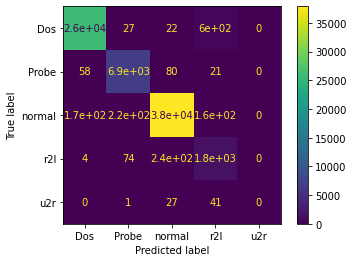

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

# dizionario
target_dict = {'Dos' : 0,
               'Probe' : 1,
               'normal' : 2,
               'r2l' : 3,
               'u2r' : 4}

disp = ConfusionMatrixDisplay(cm, target_dict)
disp.plot()

In [ ]:
mcm = multilabel_confusion_matrix(y_test, y_pred)
print(mcm)

In [ ]:
print(cm)

[[26418    12    39    18     0]
 [    4  6973    26    39     0]
 [   27    80 38353   142     0]
 [    4    13    16  2046     0]
 [    0     3     3    42     0]]


In [ ]:
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     26487
           1       0.98      0.99      0.99      7042
           2       1.00      0.99      1.00     38602
           3       0.89      0.98      0.94      2079
           4       0.00      0.00      0.00        48

    accuracy                           0.99     74258
   macro avg       0.78      0.79      0.78     74258
weighted avg       0.99      0.99      0.99     74258



In [ ]:
print('Accuracy: ', acc)
print('Precision_weighted: ', precision)
print('Recall_weighted: ', recall)
print('mcc: ', mcc)
print('f2: ', f2)

Accuracy:  0.9936976487381831
Precision_weighted:  0.9933489715112701
Recall_weighted:  0.9936976487381831
mcc:  0.9894025708708653
f2:  0.9936278937118028
